# Binoculars score exploratory data analysis

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import configuration as config
import functions.plotting as plot_funcs

/mnt/arkk/LLaMA3


In [2]:
# Load the data
data_df=pd.read_json(f'{config.BINOCULARS_DATA_PATH}/scores.json')

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace=True)
data_df.replace('OOM', np.nan, inplace=True)
data_df.dropna(inplace=True)

# Fix some d-types
data_df = data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Binoculars score': float
})

data_df.head()

,Fragment,Fragment length (tokens),Dataset,Source,String,Observer peak memory (GB),Performer peak memory (GB),Perplexity,Cross-perplexity,Binoculars score
1,1,354,cc_news-falcon7,human,If you are viewing this news story on another ...,10.549491,9.961638,0.925484,1.032989,0.895928
2,2,322,cc_news-falcon7,human,America Corp DE lifted its holdings in H. B. F...,10.077710,9.543521,1.183552,1.097678,1.078233
3,3,152,cc_news-falcon7,human,stock.\nH. B. Fuller Company Profile\nH.B. Ful...,7.823590,7.562220,1.497135,1.729557,0.865618
4,4,13,cc_news-falcon7,human,related companies with MarketBeat.com's FREE d...,6.284044,6.284044,4.000695,4.235609,0.944538
6,6,69,cc_news-falcon7,synthetic,to a “strong-buy” rating in a research note on...,6.823052,6.770480,1.788065,1.611551,1.109531


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2900 entries, 1 to 2990
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Fragment                    2900 non-null   int64  
 1   Fragment length (tokens)    2900 non-null   int64  
 2   Dataset                     2900 non-null   object 
 3   Source                      2900 non-null   object 
 4   String                      2900 non-null   object 
 5   Observer peak memory (GB)   2900 non-null   float64
 6   Performer peak memory (GB)  2900 non-null   float64
 7   Perplexity                  2900 non-null   float64
 8   Cross-perplexity            2900 non-null   float64
 9   Binoculars score            2900 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 249.2+ KB


In [4]:
human_fragments=data_df[data_df['Source'] == 'human']
synthetic_fragments=data_df[data_df['Source'] == 'synthetic']

## Perplexity vs cross-perplexity

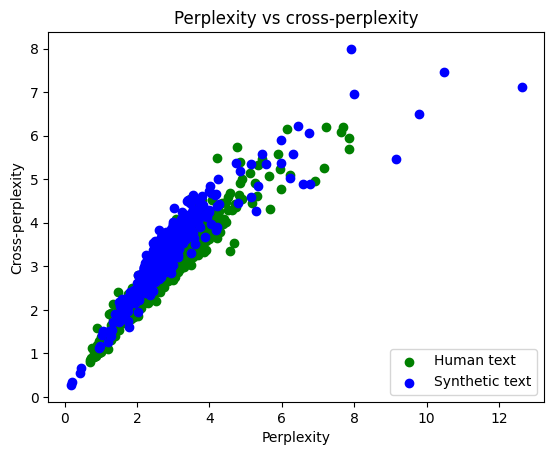

In [5]:
plt.title('Perplexity vs cross-perplexity')
plt.scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c='green', label='Human text')
plt.scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c='blue', label='Synthetic text')
plt.legend(loc='lower right')
plt.xlabel('Perplexity')
plt.ylabel('Cross-perplexity')
plt.show()

## Binoculars score distribution

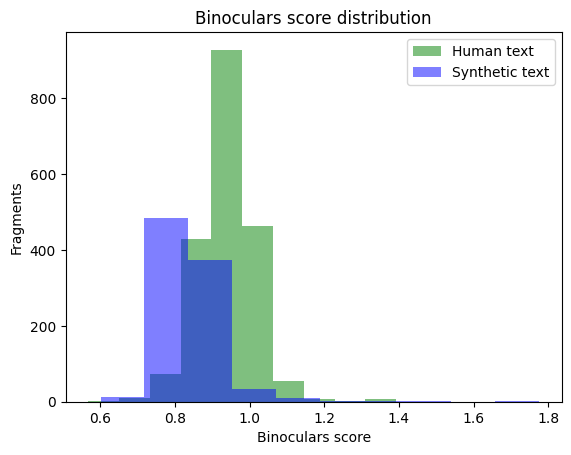

In [6]:
plt.title('Binoculars score distribution')
plt.hist(human_fragments['Binoculars score'], facecolor='green', label='Human text', alpha=0.5)
plt.hist(synthetic_fragments['Binoculars score'], facecolor='blue', label='Synthetic text', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Binoculars score')
plt.ylabel('Fragments')
plt.show()

## Binoculars score by fragment length

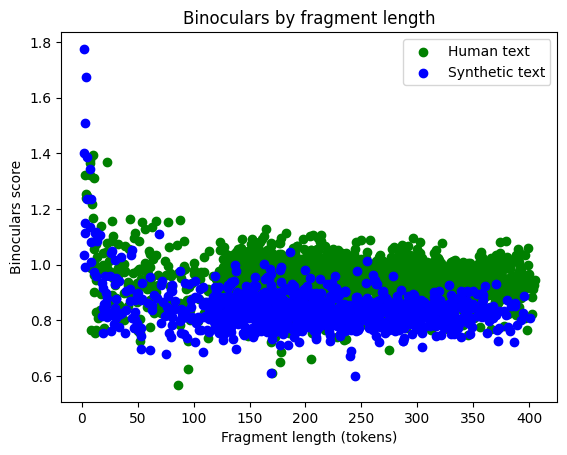

In [7]:
plt.title('Binoculars by fragment length')
plt.scatter(human_fragments['Fragment length (tokens)'], human_fragments['Binoculars score'], c='green', label='Human text')
plt.scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Binoculars score'], c='blue', label='Synthetic text')
plt.legend(loc='upper right')
plt.xlabel('Fragment length (tokens)')
plt.ylabel('Binoculars score')
plt.show()

## Fragment length distribution

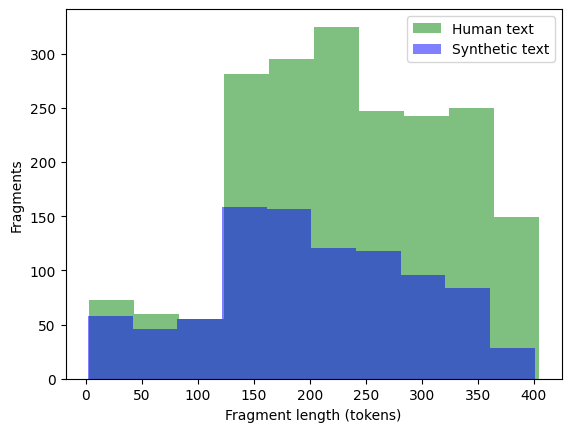

In [8]:
plt.hist(human_fragments['Fragment length (tokens)'], facecolor='green', label='Human text', alpha=0.5)
plt.hist(synthetic_fragments['Fragment length (tokens)'], facecolor='blue', label='Synthetic text', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Fragment length (tokens)')
plt.ylabel('Fragments')
plt.show()

## Brainstorming
Ok, let's pause for a second and think through the next move(s). Really need to get to a MVP quickly here. There is a lot of stuff that needs to be decided/figured out and I think we are in one of those situations were we need to get there to know what to focus on. It's too easy to get stuck making plots and running benchmarks - we need a path to a product that works because the meat of the challenge here is going to be figuring out how to deploy and present this thing. We can tweak the models etc. later.

I think rather than continuing to tune and tweak the back-end, what we need to do is set-up and API that computes this score. Then we can start thinking about how to present it. Here are some ideas:

1. Chat-bot/server/room - users can message the bot with text and it replies with analysis/verdict, or users just post text in a room/thread and the bot replies.
2. Web page - paste in text, get analysis.
3. Browser extension - flags synthetic text on web-pages.

I think the best/easiest way to set this up is as a messaging service. Users send text they want to test to a WhatsApp/Telegram/Discord etc. contact and the bot replies with the analysis. To start with we don't need any chat functionality or anything else, but that kind of thing would be easy to add later. Also, we already have bot code for matrix and discord which we could easily adapt for this.

OK, so what do we need? I think it's basically three things:

1. The scoring/report generation function. Takes some text, does the magic, returns the answer.
2. A flask API which exposes the scoring function - probably put all of that in a docker container.
3. A communicator bot for each text service we want to use - collects suspect text from user, calls the scoring function API, sends the answer back to the user.